<a href="https://colab.research.google.com/github/wanifarooq/EsrGan/blob/main/EsrGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here it is written to mount the Google Drive.  
At the Start of every Session it asks for the Authorization token from user.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing different libraries.
Registering flag whose value can be any string.

In [ ]:
import datetime
from absl import app, flags
# from absl import app
import pathlib
import cv2
import numpy as np
import yaml
import sys
import time
import tensorflow as tf
from absl import logging
from absl.flags import FLAGS
import os
import functools
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, LeakyReLU
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19
flags.DEFINE_string('f', '', 'kernel')

Setting up the function to show the different log levels and call them accordinly in different functions. The levels are as:
* logging.FATAL
* logging.ERROR
* logging.WARNING
* logging.INFO
* logging.DEBUG

In [ ]:
def set_tf_loglevel(level):
    if level >= logging.FATAL:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    elif level >= logging.ERROR:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    elif level >= logging.WARNING:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
    else:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
    logger = tf.get_logger()
    logger.disabled = True
    logger.setLevel(level)

The method ***tf.config.experimental.set_memory_growth*** works for allowing dynamic growth during the allocation/preprocessing. Nevertheless one may like to allocate from the start a specific GPU memory.
It sets same memory growth across all GPUs.   
The logic behind allocating a specific GPU memory would also be to prevent OOM memory during training sessions.   
**Note :** Memory growth must be set before GPUs have been initialized

In [ ]:
def set_memory_growth():
    numberOfGpus = tf.config.experimental.list_physical_devices('GPU')
    if numberOfGpus:
        try:
            for SingleGpu in numberOfGpus:
                tf.config.experimental.set_memory_growth(SingleGpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices('GPU')
                logging.info("Got {} Physical GPUs, {} Logical GPUs.".format(len(numberOfGpus), len(logical_gpus)))
        except RuntimeError as e:
            logging.info(e)

Loading the Yaml files 

In [ ]:
def config_loader(path):
    with open(path, 'r') as f:
        config = yaml.load(f, Loader=yaml.Loader)
    return config

Loading the TfRecord file where each Record contain Name , High Resolution image and Low Resolution image   
I have stored images as TF Records because The TFRecord format is a simple format for storing a sequence of binary records.  
Protocol buffers are a cross-platform, cross-language library for efficient serialization of data.  
Taking the values for different variables from configuration file for flip , ground truth size and other variables as described in paper 

In [ ]:
def dataLoader(configuration, key, shuffle=True, sizeOfBuffer=10240):
    dataset_configuration = configuration[key]
    logging.info("loading data {} from {}".format(key, dataset_configuration['path']))
    dataset = loadTfRecords(recordPath=dataset_configuration['path'], batchSize=configuration['batchSize'],
                            grdTSize=configuration['grdSize'], scale=configuration['scale'], shuffle=shuffle,
                            bins=dataset_configuration['bins'], flip=dataset_configuration['flip'],
                            rotation=dataset_configuration['rotation'], sizeOfBuffer=sizeOfBuffer)
    return dataset

TfLoader function continues, The parse function is called which seperates each element in the record and return the dataset for training.

In [ ]:
def loadTfRecords(recordPath, batchSize, grdTSize,
                  scale, bins=False, flip=False, rotation=False, shuffle=True, sizeOfBuffer=10240):
    compressedData = tf.data.TFRecordDataset(recordPath)
    compressedData = compressedData.repeat()
    if shuffle:
        compressedData = compressedData.shuffle(buffer_size=sizeOfBuffer)
    dataset = compressedData.map(parseRecord(grdTSize, scale, bins, flip, rotation),
                                 num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batchSize, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

Parse the Record files use the three Keys for each of the record elements.
The Keys are :
* Image name 
* Encoded high resolution image
* Encoded low resolution image 

In [ ]:
def parseRecord(grdTSize, scale, bins, flip, rotation):
    def loadRecord(record):
        if bins:
            attributes = {
                'image/img_name': tf.io.FixedLenFeature([], tf.string),
                'image/hr_encoded': tf.io.FixedLenFeature([], tf.string),
                'image/lr_encoded': tf.io.FixedLenFeature([], tf.string)}
            dic = tf.io.parse_single_example(record, attributes)
            lowerResolution = tf.image.decode_png(dic['image/lr_encoded'], channels=3)
            higherResolution = tf.image.decode_png(dic['image/hr_encoded'], channels=3)
        else:
            attributes = {
                'image/img_name': tf.io.FixedLenFeature([], tf.string),
                'image/hr_img_path': tf.io.FixedLenFeature([], tf.string),
                'image/lr_img_path': tf.io.FixedLenFeature([], tf.string)}
            dic = tf.io.parse_single_example(record, attributes)
            hr_image_encoded = tf.io.read_file(dic['image/hr_img_path'])
            lr_image_encoded = tf.io.read_file(dic['image/lr_img_path'])
            lowerResolution = tf.image.decode_png(lr_image_encoded, channels=3)
            higherResolution = tf.image.decode_png(hr_image_encoded, channels=3)

        lowerResolution, higherResolution = imageTransformation(
            grdTSize, scale, flip, rotation)(lowerResolution, higherResolution)

        return lowerResolution, higherResolution

    return loadRecord

Transforming (spliting) the high resolution image to the smaller images of ground size here it is **(128,128)** and similarly transforming (spliting) the low resolution images to smaller size images **(32,32)**.   
Using the running window to split it.   
Besides that in order to increase the randomness in distribution flip and rotation is also added.    
Data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.


In [ ]:
def imageTransformation(grdTSize, scale, flip, rotation):
    def imageTransform(lowerResolution, higherResolution):
        lowerResImgShape = tf.shape(lowerResolution)
        higherResImgShape = tf.shape(higherResolution)
        grdTShape = (grdTSize, grdTSize, tf.shape(higherResolution)[-1])
        lowerResSize = int(grdTSize / scale)
        lowerResShape = (lowerResSize, lowerResSize, tf.shape(lowerResolution)[-1])

        tf.Assert(
            tf.reduce_all(higherResImgShape >= grdTShape),
            ["Need higherResImgShape >= grdTSize, got ", higherResImgShape, grdTShape])
        tf.Assert(
            tf.reduce_all(higherResImgShape[:-1] == lowerResImgShape[:-1] * scale),
            ["Need higherResImgShape == lowerResImgShape * scale, got ",
             higherResImgShape[:-1], lowerResImgShape[:-1] * scale])
        tf.Assert(
            tf.reduce_all(higherResImgShape[-1] == lowerResImgShape[-1]),
            ["Need higherResImgShape[-1] == lowerResImgShape[-1]], got ",
             higherResImgShape[-1], lowerResImgShape[-1]])

        # randomly crop
        limit = lowerResImgShape - lowerResShape + 1
        offset = tf.random.uniform(tf.shape(lowerResImgShape), dtype=tf.int32, maxval=tf.int32.max) % limit
        lowerResolution = tf.slice(lowerResolution, offset, lowerResShape)
        higherResolution = tf.slice(higherResolution, offset * scale, grdTShape)

        # randomly left-right flip
        if flip:
            flip_case = tf.random.uniform([1], 0, 2, dtype=tf.int32)

            def flip_func(): return (tf.image.flip_left_right(lowerResolution),
                                     tf.image.flip_left_right(higherResolution))

            lowerResolution, higherResolution = tf.case(
                [(tf.equal(flip_case, 0), flip_func)],
                default=lambda: (lowerResolution, higherResolution))

        # randomly rotation
        if rotation:
            rot_case = tf.random.uniform([1], 0, 4, dtype=tf.int32)

            def rot90_func(): return (tf.image.rot90(lowerResolution, k=1),
                                      tf.image.rot90(higherResolution, k=1))

            def rot180_func(): return (tf.image.rot90(lowerResolution, k=2),
                                       tf.image.rot90(higherResolution, k=2))

            def rot270_func(): return (tf.image.rot90(lowerResolution, k=3),
                                       tf.image.rot90(higherResolution, k=3))

            lowerResolution, higherResolution = tf.case(
                [(tf.equal(rot_case, 0), rot90_func),
                 (tf.equal(rot_case, 1), rot180_func),
                 (tf.equal(rot_case, 2), rot270_func)],
                default=lambda: (lowerResolution, higherResolution))

        # scale to [0, 1]
        lowerResolution = lowerResolution / 255
        higherResolution = higherResolution / 255

        return lowerResolution, higherResolution

    return imageTransform

Learning rate schedules seek to adjust the learning rate during training by reducing the learning rate according to a pre-defined schedule.        
Here piecewise constant decay funtion is used to give the decay to learning rate after the fixed number of steps.  
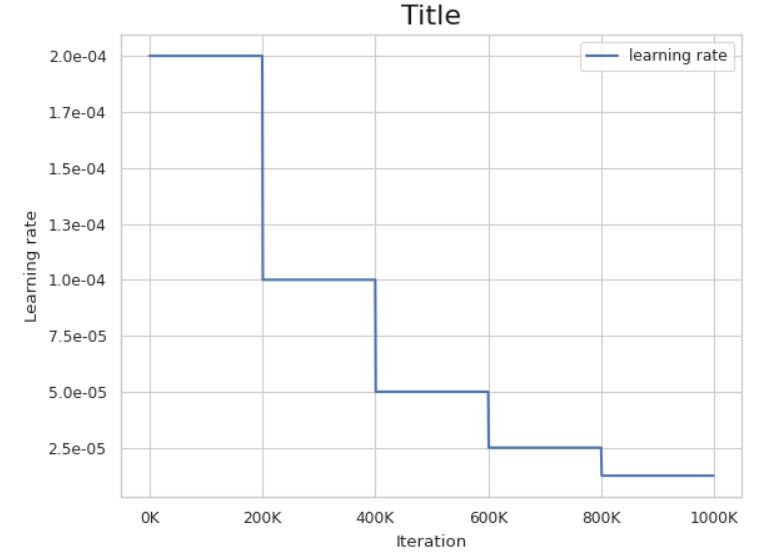


In [ ]:
def PieceWiseLearningRate(initLR, stepsLR, finalLR, name='PieceWiseLearningRate'):
    stepsLRValue = [initLR]
    for _ in range(len(stepsLR)):
        stepsLRValue.append(stepsLRValue[-1] * finalLR)
    return tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=stepsLR, values=stepsLRValue)

This function calculates the absolute loss or error.  
Here it is used to give the absolute pixel loss between two images.
Can use regularization l1 or l2

In [ ]:
def absoluteLoss(condition='l1'):
    if condition == 'l1':
        return tf.keras.losses.MeanAbsoluteError()
    elif condition == 'l2':
        return tf.keras.losses.MeanSquaredError()
    else:
        raise NotImplementedError(
            'The loss given {} is not supported.'.format(condition))

This function is used to get the content loss of two images.    
Used **VGG19** to get the features of image and the compare for the feature loss which is the content loss.  
Layer 5 can be choosed to get the low level features and 20 to the get the high level features.    
**VGG19** is a variant of VGG model which in short consists of 19 layers ***(16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer)***. There are other variants of VGG like VGG11, VGG16 and others. VGG19 has 19.6 billion FLOPs.

In [ ]:
def LossFromFeatures(condition='l1', featureLayer=54, before_act=True):
    if condition == 'l1':
        loss = tf.keras.losses.MeanAbsoluteError()
    elif condition == 'l2':
        loss = tf.keras.losses.MeanSquaredError()
    else:
        raise NotImplementedError(
            'The loss given {} is not supported.'.format(condition))
    vgg = VGG19(input_shape=(None, None, 3), include_top=False)

    if featureLayer == 22:  # Low level feature
        getOutLayer = 5
    elif featureLayer == 54:  # High level feature
        getOutLayer = 20
    else:
        raise NotImplementedError(
            'The number of the VGG layer  {} is not supported or recognized.'.format(condition))

    if before_act:
        vgg.layers[getOutLayer].activation = None

    featureExtractor = tf.keras.Model(vgg.input, vgg.layers[getOutLayer].output)

    @tf.function
    def FeatureLoss(highResolution, superResolution):
        # the input scale range is [0, 1] (vgg is [0, 255]).
        # 12.75 is rescale factor for vgg features map.
        preSrRes = preprocess_input(superResolution * 255.) / 12.75
        preHrRes = preprocess_input(highResolution * 255.) / 12.75
        srFeatures = featureExtractor(preSrRes)
        hrFeatures = featureExtractor(preHrRes)

        return loss(hrFeatures, srFeatures)

    return FeatureLoss


This function calculates the Relativistic Gan Loss:
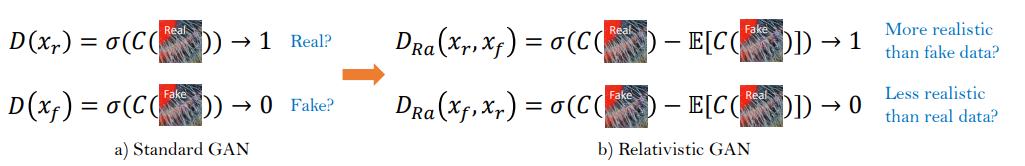



Here Rather than saying that wether image is real or not , it calculates how much real the image is **more realistic than Fake one** and **less realistic than real data.**   
Here Binary cross entropy is used to calculate the loss which compares each of the predicted probabilities to actual class output.

In [ ]:
def GeneratorLoss(ganType='ragan'):
    brCrossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    sigma = tf.sigmoid

    def raganLoss(highResIm, sprResIm):
        return 0.5 * (
                brCrossEntropy(tf.ones_like(sprResIm), sigma(sprResIm - tf.reduce_mean(highResIm))) +
                brCrossEntropy(tf.zeros_like(highResIm), sigma(highResIm - tf.reduce_mean(sprResIm))))

    def ganLoss(highResIm, sprResIm):
        return brCrossEntropy(tf.ones_like(sprResIm), sigma(sprResIm))

    if ganType == 'ragan':
        return raganLoss
    elif ganType == 'gan':
        return ganLoss
    else:
        raise NotImplementedError(
            'The loss given {} is not supported.'.format(ganType))

This function returns the __Discriminator loss__ which again measure is the relativistic loss. 
The standard discriminator in SRGAN can be expressed as D(x) = σ(C(x)), where σ is the sigmoid function and C(x) is the non-transformed discriminator output.  
Then the RaD is formulated as DRa(xr, xf ) = σ(C(xr) − Exf[C(xf )]), where Exf
[·] represents operation of taking average for all fake data in the mini-batch. The discriminator loss is then defined as:
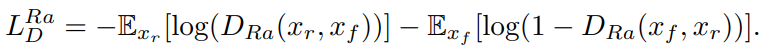  

The adversarial loss for generator is in a symmetrical form:  

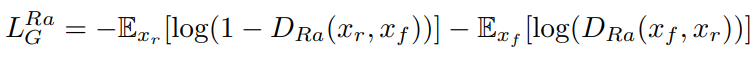

In [ ]:
def DiscriminatorLoss(ganType='ragan'):
    brCrEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    sigma = tf.sigmoid

    def raganLoss_D(highResolution, sprResolution):
        return 0.5 * (
                brCrEntropy(tf.ones_like(highResolution), sigma(highResolution - tf.reduce_mean(sprResolution))) +
                brCrEntropy(tf.zeros_like(sprResolution), sigma(sprResolution - tf.reduce_mean(highResolution))))
    
    def ganLoss_D(highResolution, sprResolution):
        real_loss = brCrEntropy(tf.ones_like(highResolution), sigma(highResolution))
        fake_loss = brCrEntropy(tf.zeros_like(sprResolution), sigma(sprResolution))
        return real_loss + fake_loss

    if ganType == 'ragan':
        return raganLoss_D
    elif ganType == 'gan':
        return ganLoss_D
    else:
        raise NotImplementedError(
            'The loss given {} is not supported.'.format(ganType))

This block of the code is used to view the progress of different operation particularly training, it consoles the progress bar the code has been taken from given github:  
https://github.com/hellock/cvbase/blob/master/cvbase/progress.py  
The _get_max_bar_width function defines the width of the bar.  
Reset Function resets for new operation to start the bar from begining.   
Update function updates it for the present operation. 

In [ ]:
class ProgressBar(object):
    def __init__(self, task_num=0, completed=0, bar_width=25):
        self.task_num = task_num
        max_bar_width = self._get_max_bar_width()
        self.bar_width = (bar_width
                          if bar_width <= max_bar_width else max_bar_width)
        self.completed = completed
        self.first_step = completed
        self.warm_up = False

    def _get_max_bar_width(self):
        if sys.version_info > (3, 3):
            from shutil import get_terminal_size
        else:
            from backports.shutil_get_terminal_size import get_terminal_size
        terminal_width, _ = get_terminal_size()
        max_bar_width = min(int(terminal_width * 0.6), terminal_width - 50)
        if max_bar_width < 10:
            logging.info('terminal width is too small ({}), please consider '
                         'widen the terminal for better progressbar '
                         'visualization'.format(terminal_width))
            max_bar_width = 10
        return max_bar_width

    def reset(self):
       self.completed = 0

    def update(self, inf_str=''):
        self.completed += 1
        if not self.warm_up:
            self.start_time = time.time() - 1e-2
            self.warm_up = True
        elapsed = time.time() - self.start_time
        fps = (self.completed - self.first_step) / elapsed
        percentage = self.completed / float(self.task_num)
        mark_width = int(self.bar_width * percentage)
        bar_chars = '>' * mark_width + ' ' * (self.bar_width - mark_width)
        stdout_str = \
            '\rTraining [{}] {}/{}, {}  {:.1f} step/sec'
        sys.stdout.write(stdout_str.format(
            bar_chars, self.completed, self.task_num, inf_str, fps))
        sys.stdout.flush()

This function is used to return the two image from the single high resolution image : 


* The high resolution image which is same as of the input image but just dropped the pixels which are exceding the length of the times of scale to low resolution.  
* The low resolution image which is decreased by 1/scale of generated high resolution image.

In [ ]:
def createLHPair(hResImage, scale=4.):
    lowResHeight, lowResWidth = hResImage.shape[0] // scale, hResImage.shape[1] // scale
    highResHeight, highResWidth = lowResHeight * scale, lowResWidth * scale
    highResImage = hResImage[:highResHeight, :highResWidth, :]
    lowResImage = imResizeNp(highResImage, 1 / scale)
    return lowResImage, highResImage

Converting the tensor to image having the number of levels equal to 256

In [ ]:
def tensorToImage(tensor):
    return (np.squeeze(tensor.numpy()).clip(0, 1) * 255).astype(np.uint8)

Assign the weights to the model parameters for the network interpolation for different values of alpha as:  
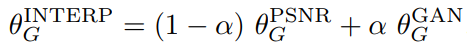

In [ ]:
def weightChanger(model, parameters1, parameters2, alpha=1.0):
    for i, var in enumerate(model.trainable_variables):
        var.assign((1 - alpha) * parameters1[i] + alpha * parameters2[i])

This code is direct implementation of the official code of paper changed to tensorflow from pytorch:
https://github.com/open-mmlab/mmsr   
This code converts the image from highResolution using cubic to low resolution or low resolution to high resolution using the bicubic interpolation.  
The scale should be the same for H and W.  
input: img: Numpy, HWC RBG [0,1]  
output: HWC RBG [0,1] w/o round  
Return the desired dimension order for performing the resize.  The
strategy is to perform the resize first along the dimension with the smallest scale factor.
Get weights and indices accordingly, process them symmetrically and get the final output.


In [ ]:
def imResizeNp(img, scale, antialiasing=True):
    inputHeight, inputWidth, inputChannel = img.shape

    _, outputHeight, outputWidth = inputChannel, np.ceil(inputHeight * scale), np.ceil(inputWidth * scale)
    outputHeight, outputWidth = outputHeight.astype(np.int64), outputWidth.astype(np.int64)
    KernelWidth = 4
    kernel = 'cubic'
    heightWeigths, heightIndices, lenSymHs, heightSymLen = weigthIndicesCalculation(
        inputHeight, outputHeight, scale, kernel, KernelWidth, antialiasing)
    widthWeight, weightIndices, lenSymWs, weigthSymLen = weigthIndicesCalculation(
        inputWidth, outputWidth, scale, kernel, KernelWidth, antialiasing)
    
    augmentedImage = np.zeros(((inputHeight + lenSymHs + heightSymLen), inputWidth, inputChannel))
    augmentedImage[lenSymHs:lenSymHs + inputHeight] = img

    patchSym = img[:lenSymHs, :, :]
    symPatchInv = patchSym[::-1]
    augmentedImage[0:lenSymHs] = symPatchInv

    patchSym = img[-heightSymLen:, :, :]
    symPatchInv = patchSym[::-1]
    augmentedImage[lenSymHs + inputHeight:lenSymHs + inputHeight + heightSymLen] = symPatchInv

    firstOutput = np.zeros((outputHeight, inputWidth, inputChannel))
    KernelWidth = heightWeigths.shape[1]
    for i in range(outputHeight):
        idx = int(heightIndices[i][0])
        firstOutput[i, :, 0] = heightWeigths[i].dot(
            augmentedImage[idx:idx + KernelWidth, :, 0].transpose(0, 1))
        firstOutput[i, :, 1] = heightWeigths[i].dot(
            augmentedImage[idx:idx + KernelWidth, :, 1].transpose(0, 1))
        firstOutput[i, :, 2] = heightWeigths[i].dot(
            augmentedImage[idx:idx + KernelWidth, :, 2].transpose(0, 1))

    
    firstOutputAug = np.zeros((outputHeight, inputWidth + lenSymWs + weigthSymLen, inputChannel))
    firstOutputAug[:, lenSymWs:lenSymWs + inputWidth] = firstOutput

    patchSym = firstOutput[:, :lenSymWs, :]
    symPatchInv = patchSym[:, ::-1]
    firstOutputAug[:, 0:lenSymWs] = symPatchInv

    patchSym = firstOutput[:, -weigthSymLen:, :]
    symPatchInv = patchSym[:, ::-1]
    firstOutputAug[:, lenSymWs + inputWidth:lenSymWs + inputWidth + weigthSymLen] = \
        symPatchInv

    secondOutput = np.zeros((outputHeight, outputWidth, inputChannel))
    KernelWidth = widthWeight.shape[1]
    for i in range(outputWidth):
        idx = int(weightIndices[i][0])
        secondOutput[:, i, 0] = firstOutputAug[:, idx:idx + KernelWidth, 0].dot(
            widthWeight[i])
        secondOutput[:, i, 1] = firstOutputAug[:, idx:idx + KernelWidth, 1].dot(
            widthWeight[i])
        secondOutput[:, i, 2] = firstOutputAug[:, idx:idx + KernelWidth, 2].dot(
            widthWeight[i])

    return secondOutput.clip(0, 255)

This is the cube kernel sampler taken from the original code to return the cube of the interest to be used for the generation of the image which is used for both testing and to calculate the PSNR score and SSIM.

In [ ]:
def cubeSampler(x):
    absolutex = np.abs(x)
    absolutex2 = absolutex ** 2
    absolutex3 = absolutex ** 3
    return (1.5 * absolutex3 - 2.5 * absolutex2 + 1) * ((absolutex <= 1).astype(np.float64)) \
        + (-0.5 * absolutex3 + 2.5 * absolutex2 - 4 * absolutex + 2) * (
            ((absolutex > 1) * (absolutex <= 2)).astype(np.float64))

A modified kernel to simultaneously interpolate and antialias.  
Kernel width depends on the scale which determines the Output-space coordinates.  
Calculate the inverse mapping such that 0.5 in output space maps to 0.5 in input space, and 0.5+scale in output space maps to 1.5 in input space.   
Detemines the left-most pixel that can be involved in the computation and the maximum number of pixels that can be involved in the computation.  
**Note:** it's OK to use an extra pixel here; if the corresponding weights are all zero, it will be eliminated at the end of this function.  
The indices of the input pixels involved in computing the k-th output
pixel are in row k of the indices matrix.   
The weights used to compute the k-th output pixel are in row k of the
weights matrix.
Then Apply the cubic kernel. 
Normalize the weights matrix so that each row sums to 1.  
If a column in weights is all zero, get rid of it.

In [ ]:
def weigthIndicesCalculation(in_length, intrestedLength, scale, kernel,
                               KernelWidth, antialiasing):
    if (scale < 1) and (antialiasing):
        
        KernelWidth = KernelWidth / scale
    x = np.linspace(1, intrestedLength, intrestedLength)
    u = x / scale + 0.5 * (1 - 1 / scale)
    left = np.floor(u - KernelWidth / 2)
    P = (np.ceil(KernelWidth) + 2).astype(np.int32)
    indices = left.reshape(int(intrestedLength), 1).repeat(P, axis=1) + \
        np.linspace(0, P - 1, P).reshape(1, int(P)).repeat(intrestedLength, axis=0)
    centerToPixel = \
        u.reshape(int(intrestedLength), 1).repeat(P, axis=1) - indices
    
    if (scale < 1) and (antialiasing):
        weights = scale * cubeSampler(centerToPixel * scale)
    else:
        weights = cubeSampler(centerToPixel)
    
    sumWeights = np.sum(weights, 1).reshape(int(intrestedLength), 1)
    weights = weights / sumWeights.repeat(P, axis=1)
    tmpWeights = np.sum((weights == 0), 0)
    if not np.isclose(tmpWeights[0], 0, rtol=1e-6):
        indices = indices[:, 1:1 + int(P) - 2]
        weights = weights[:, 1:1 + int(P) - 2]
    if not np.isclose(tmpWeights[-1], 0, rtol=1e-6):
        indices = indices[:, 0:0 + int(P) - 2]
        weights = weights[:, 0:0 + int(P) - 2]
    weights = weights.copy()
    indices = indices.copy()
    sideLenSym = -indices.min() + 1
    endLenSym = indices.max() - in_length
    indices = indices + sideLenSym - 1
    return weights, indices, int(sideLenSym), int(endLenSym)

This function calculates the absolute Peak signal to noise ratio .  
Taking the root mean square of the pixel differences between the two images. 
The mathematical representation of the PSNR is as follows:
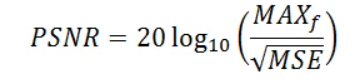  
Where the mean square error is: 
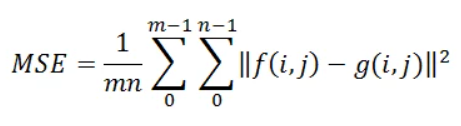  
The proposal is that the higher the PSNR, the better degraded image has been reconstructed to match the original image and the better the reconstructive algorithm.  This would occur because we wish to minimize the MSE between images with respect the maximum signal value of the image.



In [ ]:
def psnrCalculator(firstImage, secondImage):
    firstImage = firstImage.astype(np.float64)
    secondImage = secondImage.astype(np.float64)
    meanSqError = np.mean((firstImage - secondImage)**2)
    if meanSqError == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(meanSqError))

SSIM is used as a metric to measure the similarity between two given images. 
The Structural Similarity Index (SSIM) metric extracts 3 key features from an image:  
   * Luminance 
   * Contrast
   * Structure   
**Luminance:** Luminance is measured by averaging over all the pixel values. Its denoted by μ (Mu) and the formula is given below.  
**Contrast:** It is measured by taking the standard deviation (square root of variance) of all the pixel values. It is denoted by σ (sigma) and represented by the formula below.  
**Structure:** The structural comparison is done by using a consolidated formula (more on that later) but in essence, we divide the input signal with its standard deviation so that the result has unit standard deviation which allows for a more robust comparison.  
And finally, the SSIM score is given by,  
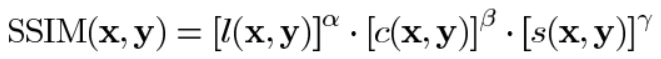  


where α > 0, β > 0, γ > 0 denote the relative importance of each of the metrics. To simplify the expression, if we assume, α = β = γ = 1 and C3 = C2/2, we can get,  

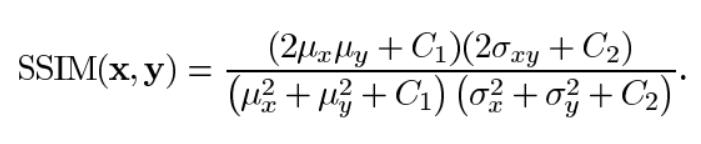


In [ ]:
def strSimInxMeasure(firstImage, secondImage):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    firstImage = firstImage.astype(np.float64)
    secondImage = secondImage.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    μ1 = cv2.filter2D(firstImage, -1, window)[5:-5, 5:-5]  # valid
    μ2 = cv2.filter2D(secondImage, -1, window)[5:-5, 5:-5]
    μ1_sqr = μ1**2
    μ2_sqr = μ2**2
    μ1_μ2 = μ1 * μ2
    σ1_sq = cv2.filter2D(firstImage**2, -1, window)[5:-5, 5:-5] - μ1_sqr
    σ2_sq = cv2.filter2D(secondImage**2, -1, window)[5:-5, 5:-5] - μ2_sqr
    σ12 = cv2.filter2D(firstImage * secondImage, -1, window)[5:-5, 5:-5] - μ1_μ2

    structSimMap = ((2 * μ1_μ2 + C1) * (2 * σ12 + C2)) \
        / ((μ1_sqr + μ2_sqr + C1) * (σ1_sq + σ2_sq + C2))
    return structSimMap.mean()
def StructSimIndex(firstImage, secondImage):
    if not firstImage.shape == secondImage.shape:
        raise ValueError('Input images must have the same dimensions.')
    if firstImage.ndim == 2:
        return strSimInxMeasure(firstImage, secondImage)
    elif firstImage.ndim == 3:
        if firstImage.shape[2] == 3:
            ssims = []
            for _ in range(3):
                ssims.append(strSimInxMeasure(firstImage, secondImage))
            return np.array(ssims).mean()
        elif firstImage.shape[2] == 1:
            return strSimInxMeasure(np.squeeze(firstImage), np.squeeze(secondImage))
    else:
        raise ValueError('Wrong input image dimensions.')

Given a digital pixel represented in **RGB format, 8 bits per sample**, where **0** and **255** represents the **black** and **white** color, respectively, the **YCbCr** components can be obtained according to equations :

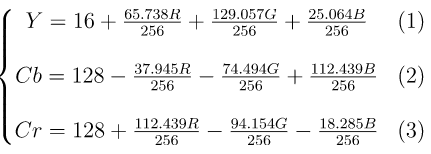

* __YCbCr__ represents colors as combinations of a brightness signal and two chroma signals. In __YCbCr__, Y is luma (brightness), Cb is blue minus luma (B-Y) and Cr is red minus luma (R-Y).
* During creation of __YCbCr__ signals from RGB (the encoding process), higher frequency signal content is removed from the Cb and Cr channels to compress the signal. 

In [ ]:
def RGB2YCbCr(img, only_y=True):
    inImgDataType = img.dtype
    img.astype(np.float32)
    if inImgDataType != np.uint8:
        img *= 255.
    img = img[:, :, ::-1]
    if only_y:
        rlt = np.dot(img, [24.966, 128.553, 65.481]) / 255.0 + 16.0
    else:
        rlt = np.matmul(
            img, [[24.966, 112.0, -18.214],
                  [128.553, -74.203, -93.786],
                  [65.481, -37.797, 112.0]]) / 255.0 + [16, 128, 128]
    if inImgDataType == np.uint8:
        rlt = rlt.round()
    else:
        rlt /= 255.
    return rlt.astype(inImgDataType)

Normal intialization of the kernel with scale   
Initializer is capable of adapting its scale to the shape of weights tensors.  
With distribution="truncated_normal" or "untruncated_normal", samples are drawn from a truncated/untruncated normal distribution with a mean of zero and a standard deviation (after truncation, if used) **stddev = sqrt(scale / n)**, where **n** is:  
number of input units in the weight tensor, if **mode="fan_in"**

In [ ]:
def IntialKernelNormalization(scale=1.0, seed=None):
    scale = 2. * scale
    return tf.keras.initializers.VarianceScaling(
        scale=scale, mode='fan_in', distribution="truncated_normal", seed=seed)

A regularizer that applies a L2 regularization penalty.  
The L2 regularization penalty is computed as: loss = **l2 * reduce_sum(square(x))**

In [ ]:
def weightDecayer(decay=5e-4):
    return tf.keras.regularizers.l2(decay)

Batch normalisation normalises a layer input by subtracting the mini-batch mean and dividing it by the mini-batch standard deviation. Mini-batch refers to one batch of data supplied for any given epoch, a subset of the whole training data.
The normalisation ensures that the inputs have a mean of 0 and a standard deviation of 1, meaning that the input distribution to every neuron will be the same, thereby fixing the problem of internal covariate shift and providing regularisation.  
Batch normalisation adds two trainable parameters, gamma γ and beta β, which can scale and shift the normalised value.

In [ ]:
class BN(tf.keras.layers.BatchNormalization):
    def __init__(self, axis=-1, momentum=0.9, epsilon=1e-5, center=True,
                 scale=True, name=None, **kwargs):
        super(BN, self).__init__(
            axis=axis, momentum=momentum, epsilon=epsilon, center=center,
            scale=scale, name=name, **kwargs)

    def call(self, inputData, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(inputData, training)

The Proposed Architecture for the PSNR or Generator of ESRGAN is given as below:

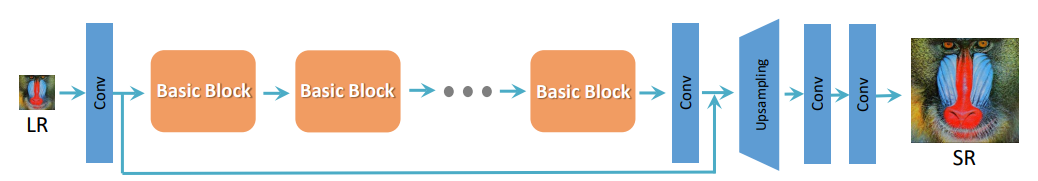

Firstly, we implement the architecture of the basic block which is also called the Residual dense block:

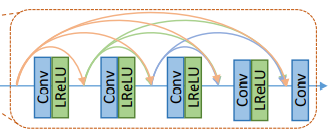

In [ ]:
class RDB_5C(tf.keras.layers.Layer):
  def __init__(self, numberOfFilters=64, growthChannel=32, beta=0.2, weightDecay=0., name='RDB5C',
                 **kwargs):
        super(RDB_5C, self).__init__(name=name, **kwargs)
        # gc: growth channel, i.e. intermediate channels
        self.beta = beta
        leaky_RelU = functools.partial(LeakyReLU, alpha=0.2)
        conv_2DLayer = functools.partial(Conv2D, kernel_size=3, padding='same',
                                         kernel_initializer=IntialKernelNormalization(0.1),
                                         bias_initializer='zeros', kernel_regularizer=weightDecayer(weightDecay))
        self.conv1 = conv_2DLayer(filters=growthChannel, activation=leaky_RelU())
        self.conv2 = conv_2DLayer(filters=growthChannel, activation=leaky_RelU())
        self.conv3 = conv_2DLayer(filters=growthChannel, activation=leaky_RelU())
        self.conv4 = conv_2DLayer(filters=growthChannel, activation=leaky_RelU())
        self.conv5 = conv_2DLayer(filters=numberOfFilters, activation=leaky_RelU())
  def call(self, inputData):
        inputData1 = self.conv1(inputData)
        inputData2 = self.conv2(tf.concat([inputData, inputData1], 3))
        inputData3 = self.conv3(tf.concat([inputData, inputData1, inputData2], 3))
        inputData4 = self.conv4(tf.concat([inputData, inputData1, inputData2, inputData3], 3))
        inputData5 = self.conv5(tf.concat([inputData, inputData1, inputData2, inputData3, inputData4], 3))
        return inputData5 * self.beta + inputData

Now we have to implement the architecture of the residual in residual dense block which is the combination of the three basic blocks as demonstarted. 

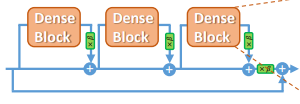

In [ ]:
class ResInResDenseBlock(tf.keras.layers.Layer):
  def __init__(self, numberOfFilters=64, growthChannel=32, beta=0.2, weightDecay=0., name='RRDB',
                 **kwargs):
        super(ResInResDenseBlock, self).__init__(name=name, **kwargs)
        self.beta = beta
        self.rDB5c_1 = RDB_5C(numberOfFilters, growthChannel, beta=beta, weightDecay=weightDecay)
        self.rDB5c_2 = RDB_5C(numberOfFilters, growthChannel, beta=beta, weightDecay=weightDecay)
        self.rDB5c_3 = RDB_5C(numberOfFilters, growthChannel, beta=beta, weightDecay=weightDecay)
  def call(self, inputData):
        output = self.rDB5c_1(inputData)
        output = self.rDB5c_2(output)
        output = self.rDB5c_3(output)
        return output * self.beta + inputData

Finally we have to merge the 23 residual in residual dense blocks to form the final architecture of PSNR network or Generator of the ESRGAN.
The complete Architecture is demonstrated as below:

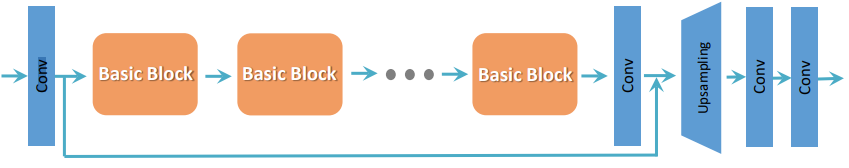

**First  :**  Call definition calling the defined layers (architecture).  
**Second :** This part of the code does the upsampling of the image.   
**Third  :**  Applying the final two convolution layers as described in the Architecture.

In [ ]:
def Residual_in_residualDenseBlock(image_size, input_channel, network_dimensions, growthChannels=32, weightDecay=0.,
                                   name='RRDB_model'):
    numberOfFilters, nrOfBlocks = network_dimensions['numFilters'], network_dimensions['numBlocks']
    leaky_RelU = functools.partial(LeakyReLU, alpha=0.2)
    singleRRDB = functools.partial(ResInResDenseBlock, numberOfFilters=numberOfFilters, growthChannel=growthChannels,
                                   weightDecay=weightDecay)
    singleConv = functools.partial(Conv2D, kernel_size=3, padding='same', bias_initializer='zeros',
                                   kernel_initializer=IntialKernelNormalization(),
                                   kernel_regularizer=weightDecayer(weightDecay))
    blockChain23 = tf.keras.Sequential([singleRRDB(name="RRDB_{}".format(i)) for i in range(nrOfBlocks)],
                                       name='RRDB_chain')

    # First
    inputData = inputs = Input([image_size, image_size, input_channel], name='input_image')
    featureMap = singleConv(filters=numberOfFilters, name='conv_first')(inputData)
    featureMap_RRDChain = blockChain23(featureMap)
    chain = singleConv(filters=numberOfFilters, name='conv_chain')(featureMap_RRDChain)
    featureMap = featureMap + chain

    # second

    imageHeight = tf.shape(featureMap)[1] if image_size is None else image_size
    imageWidth = tf.shape(featureMap)[2] if image_size is None else image_size
    resizedImage = tf.image.resize(featureMap, [imageHeight * 2, imageWidth * 2], method='nearest', name='upsampler1')
    featureMap = singleConv(filters=numberOfFilters, activation=leaky_RelU(), name='upsampleconv_1')(resizedImage)
    resizedImage = tf.image.resize(featureMap, [imageHeight * 4, imageWidth * 4], method='nearest', name='upsampler2')

    # Third
    featureMap = singleConv(filters=numberOfFilters, activation=leaky_RelU(), name='upsampleconv_2')(resizedImage)
    featureMap = singleConv(filters=numberOfFilters, activation=leaky_RelU(), name='conv_hr')(featureMap)
    output = singleConv(filters=input_channel, name='conv_last')(featureMap)

    return Model(inputs, output, name=name)

Now we define the architecture for the Discriminator and is implemented as below:

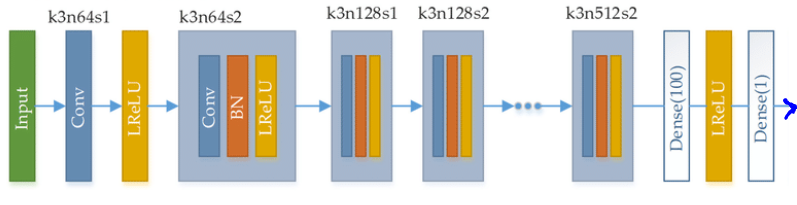

In [ ]:
def DiscriminatorRela(inputSize, channels, numberOfFilters=64, weightDecay=0., name='Discriminator'):
    leaky_RelU = functools.partial(LeakyReLU, alpha=0.2)
    conv_1 = functools.partial(Conv2D,
                               kernel_size=3, strides=1, padding='same',
                               kernel_initializer=IntialKernelNormalization(),
                               kernel_regularizer=weightDecayer(weightDecay))
    conv_2 = functools.partial(Conv2D,
                               kernel_size=4, strides=2, padding='same',
                               kernel_initializer=IntialKernelNormalization(),
                               kernel_regularizer=weightDecayer(weightDecay))
    denseLayer = functools.partial(Dense, kernel_regularizer=weightDecayer(weightDecay))

    inputData = inputs = Input(shape=(inputSize, inputSize, channels))

    inputData = conv_1(filters=numberOfFilters, name='conv0_0')(inputData)
    inputData = leaky_RelU()(inputData)
    inputData = conv_2(filters=numberOfFilters, use_bias=False, name='conv0_1')(inputData)
    inputData = leaky_RelU()(BN(name='bn0_1')(inputData))

    inputData = conv_1(filters=numberOfFilters * 2, use_bias=False, name='conv1_0')(inputData)
    inputData = leaky_RelU()(BN(name='bn1_0')(inputData))
    inputData = conv_2(filters=numberOfFilters * 2, use_bias=False, name='conv1_1')(inputData)
    inputData = leaky_RelU()(BN(name='bn1_1')(inputData))

    inputData = conv_1(filters=numberOfFilters * 4, use_bias=False, name='conv2_0')(inputData)
    inputData = leaky_RelU()(BN(name='bn2_0')(inputData))
    inputData = conv_2(filters=numberOfFilters * 4, use_bias=False, name='conv2_1')(inputData)
    inputData = leaky_RelU()(BN(name='bn2_1')(inputData))

    inputData = conv_1(filters=numberOfFilters * 8, use_bias=False, name='conv3_0')(inputData)
    inputData = leaky_RelU()(BN(name='bn3_0')(inputData))
    inputData = conv_2(filters=numberOfFilters * 8, use_bias=False, name='conv3_1')(inputData)
    inputData = leaky_RelU()(BN(name='bn3_1')(inputData))

    inputData = conv_1(filters=numberOfFilters * 8, use_bias=False, name='conv4_0')(inputData)
    inputData = leaky_RelU()(BN(name='bn4_0')(inputData))
    inputData = conv_2(filters=numberOfFilters * 8, use_bias=False, name='conv4_1')(inputData)
    inputData = leaky_RelU()(BN(name='bn4_1')(inputData))

    inputData = Flatten()(inputData)
    inputData = denseLayer(units=100, activation=leaky_RelU(), name='linear1')(inputData)
    output = denseLayer(units=1, name='linear2')(inputData)

    return Model(inputs, output, name=name)

**Here we train the PSNR network**.  
* First created the logger to print the fatal logs only, because we are already aware of other logs above
* Configure the Gpu and enalbe the memory growth
* Load the psnr configuration file.
* Define the generator/ psnr network taking the size of input image, the channels , the number of filters and the number of residual in residual dense blocks.
* load the dataset which is saved as TFrecord file
* Define optimizer which is Adam in our case
* Define different type of losses
* define/ Load the checkpoints
* Call the training loop step function
* save the checkpoints and the logs 
   


In [ ]:
flags.DEFINE_string('psnr_yaml', '/content/drive/MyDrive/EsrGans/configs/psnr.yaml', 'path of the configuration file psnr')
flags.DEFINE_string('esrgan_yaml', '/content/drive/MyDrive/EsrGans/configs/esrgan.yaml', 'config file path')
flags.DEFINE_string('gpu', '0', 'which gpu to use')

def psnrTrain(_):
    os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
    set_tf_loglevel(logging.FATAL)
    os.environ['CUDA_VISIBLE_DEVICES'] = FLAGS.gpu
    set_memory_growth()
    psnrConfig = config_loader(FLAGS.psnr_yaml)
    model = Residual_in_residualDenseBlock(psnrConfig['inputSize'], psnrConfig['nrInpChannel'], psnrConfig['network_G'])
    model.summary(line_length=100)
    trainingData = dataLoader(psnrConfig, 'train', shuffle=True)
    learningRate = PieceWiseLearningRate(psnrConfig['initLr'], psnrConfig['lrSteps'], psnrConfig['lrRate'])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate, beta_1=psnrConfig['beta1_G'],
                                         beta_2=psnrConfig['beta2_G'])
    pixelAbsLoss = absoluteLoss(condition=psnrConfig['pixelRegularization'])
    checkpoint_dir = '/content/drive/MyDrive/EsrGans/checkpoints/' + psnrConfig['netName']
    checkpoint = tf.train.Checkpoint(step=tf.Variable(0, name='step'), optimizer=optimizer, model=model)
    manager = tf.train.CheckpointManager(checkpoint=checkpoint, directory=checkpoint_dir, max_to_keep=3)
    if manager.latest_checkpoint:
        checkpoint.restore(manager.latest_checkpoint)
        print('[*] load checkpoint from {} at step {}.'.format(
            manager.latest_checkpoint, checkpoint.step.numpy()))
    else:
        print("[*] training from scratch.")
    @tf.function
    def trainer(lowResolution, highResolution):
        with tf.GradientTape() as tape:
            superResImage = model(lowResolution, training=True)
            # superResImage= highResolution -0.865788
            lossValues = {}
            lossValues['reg'] = tf.reduce_sum(model.losses)
            lossValues['pixel'] = psnrConfig['weightPixel'] * pixelAbsLoss(highResolution, superResImage)
            finalLoss = tf.add_n([l for l in lossValues.values()])

        grads = tape.gradient(finalLoss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        return finalLoss, lossValues
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    logWriter = tf.summary.create_file_writer('/content/drive/MyDrive/EsrGans/logs/' + psnrConfig['netName'] + current_time)
    prog_bar = ProgressBar(psnrConfig['nrIter'], checkpoint.step.numpy())
    stepToDo = max(psnrConfig['nrIter'] - checkpoint.step.numpy(), 0)

    for lowResolution, highResolution in trainingData.take(stepToDo):
        checkpoint.step.assign_add(1)
        nrIter = checkpoint.step.numpy()
        finalLoss, lossValues = trainer(lowResolution, highResolution)
        prog_bar.update("loss={:.4f}, lr={:.1e}".format(finalLoss.numpy(), optimizer.lr(nrIter).numpy()))
        if nrIter % 10 == 0:
            with logWriter.as_default():
                tf.summary.scalar('finalLoss/step', finalLoss, step=nrIter)
                for k, l in lossValues.items():
                    tf.summary.scalar('loss/{}'.format(k), l, step=nrIter)
                tf.summary.scalar('learningRate', optimizer.lr(nrIter), step=nrIter)
        if nrIter % psnrConfig['saveSteps'] == 0:
            manager.save()
            print("\n[*] save checkpoint file at {}".format(manager.latest_checkpoint))
    print("\n[*] training done!")


**Here we are training the Relativistic Generator and the Relativistic Discriminator.**  
**Note :** The Generatotr architecture is same as that of PSNR network infact it is same model , just we have different loss functions and the number of losses, thus here generator training makes the generator better to the already pre trained PSNR.

In [ ]:
def esrGan(_):
    os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
    set_tf_loglevel(logging.FATAL)
    os.environ['CUDA_VISIBLE_DEVICES'] = FLAGS.gpu
    set_memory_growth()
    esrGanConfig = config_loader(FLAGS.esrgan_yaml)
    RelativisticGenerator = Residual_in_residualDenseBlock(esrGanConfig['inputSize'], esrGanConfig['nrInpChannel'],
                                                           esrGanConfig['network_G'])
    RelativisticGenerator.summary(line_length=80)
    RelativisticDiscrimintor = DiscriminatorRela(esrGanConfig['grdSize'], esrGanConfig['nrInpChannel'])
    RelativisticDiscrimintor.summary(line_length=80)
    trainingData = dataLoader(esrGanConfig, 'train', shuffle=False)
    learningRate_G = PieceWiseLearningRate(esrGanConfig['initLr_G'], esrGanConfig['lrSteps'], esrGanConfig['lrRate'])
    learningRate_D = PieceWiseLearningRate(esrGanConfig['initLr_D'], esrGanConfig['lrSteps'], esrGanConfig['lrRate'])
    optimizer_G = tf.keras.optimizers.Adam(learning_rate=learningRate_G, beta_1=esrGanConfig['beta1_G'],
                                           beta_2=esrGanConfig['beta2_G'])
    optimizer_D = tf.keras.optimizers.Adam(learning_rate=learningRate_D, beta_1=esrGanConfig['beta1_D'],
                                           beta_2=esrGanConfig['beta2_D'])
    pixelAbsLoss = absoluteLoss(condition=esrGanConfig['pixelRegularization'])
    featureLosses = LossFromFeatures(condition=esrGanConfig['featureRegularization'])
    ganLossOr = GeneratorLoss(ganType=esrGanConfig['ganType'])
    dcrtLoss = DiscriminatorLoss(ganType=esrGanConfig['ganType'])
    checkpoint_dir = '/content/drive/MyDrive/EsrGans/checkpoints/' + esrGanConfig['netName']
    checkpoint = tf.train.Checkpoint(step=tf.Variable(0, name='step'), optimizer_G=optimizer_G, optimizer_D=optimizer_D,
                                     model=RelativisticGenerator, RelativisticDiscrimintor=RelativisticDiscrimintor)
    manager = tf.train.CheckpointManager(checkpoint=checkpoint, directory=checkpoint_dir, max_to_keep=3)
    if manager.latest_checkpoint:
        checkpoint.restore(manager.latest_checkpoint)
        print('[*] load checkpoint from {} at step {}.'.format(manager.latest_checkpoint, checkpoint.step.numpy()))
    else:
        if esrGanConfig['preTrainedName'] is not None:
            psnrDir = '/content/drive/MyDrive/EsrGans/checkpoints/' + esrGanConfig['preTrainedName']
            if tf.train.latest_checkpoint(psnrDir):
                checkpoint.restore(tf.train.latest_checkpoint(psnrDir))
                checkpoint.step.assign(0)
                print("[*] training from pretrain model {}.".format(psnrDir))
            else:
                print("[*] cannot find pretrain model {}.".format(psnrDir))
        else:
            print("[*] training from scratch.")
    @tf.function
    def trainer(lowRsImage, highRsImage):
        with tf.GradientTape(persistent=True) as tape:
            sprResImage = RelativisticGenerator(lowRsImage, training=True)
            # sprResImage = highRsImage - 0.865788
            highResImDxOut = RelativisticDiscrimintor(highRsImage, training=True)
            sprResImDxOut = RelativisticDiscrimintor(sprResImage, training=True)
            lossValues_G = {}
            lossValues_D = {}
            lossValues_G['reg'] = tf.reduce_sum(RelativisticGenerator.losses)
            lossValues_D['reg'] = tf.reduce_sum(RelativisticDiscrimintor.losses)
            lossValues_G['pixel'] = esrGanConfig['weightPixel'] * pixelAbsLoss(highRsImage, sprResImage)
            lossValues_G['feature'] = esrGanConfig['weightFeature'] * featureLosses(highRsImage, sprResImage)
            lossValues_G['gan'] = esrGanConfig['weightGan'] * ganLossOr(highResImDxOut, sprResImDxOut)
            lossValues_D['gan'] = dcrtLoss(highResImDxOut, sprResImDxOut)
            finalLoss_G = tf.add_n([l for l in lossValues_G.values()])
            finalLoss_D = tf.add_n([l for l in lossValues_D.values()])
        grads_G = tape.gradient(finalLoss_G, RelativisticGenerator.trainable_variables)
        grads_D = tape.gradient(finalLoss_D, RelativisticDiscrimintor.trainable_variables)
        optimizer_G.apply_gradients(zip(grads_G, RelativisticGenerator.trainable_variables))
        optimizer_D.apply_gradients(zip(grads_D, RelativisticDiscrimintor.trainable_variables))

        return finalLoss_G, finalLoss_D, lossValues_G, lossValues_D
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    logWriter = tf.summary.create_file_writer('/content/drive/MyDrive/EsrGans/logs/' + esrGanConfig['netName'] + current_time)
    prog_bar = ProgressBar(esrGanConfig['nrIter'], checkpoint.step.numpy())
    stepToDo = max(esrGanConfig['nrIter'] - checkpoint.step.numpy(), 0)

    for lowRsImage, highRsImage in trainingData.take(stepToDo):
        checkpoint.step.assign_add(1)
        nrIter = checkpoint.step.numpy()
        finalLoss_G, finalLoss_D, lossValues_G, lossValues_D = trainer(lowRsImage, highRsImage)
        prog_bar.update("loss_G={:.4f}, loss_D={:.4f}, lr_G={:.1e}, lr_D={:.1e}".format(
            finalLoss_G.numpy(), finalLoss_D.numpy(), optimizer_G.lr(nrIter).numpy(),
            optimizer_D.lr(nrIter).numpy()))
        if nrIter % 10 == 0:
            with logWriter.as_default():
                tf.summary.scalar('finalLoss_G/nrIter', finalLoss_G, step=nrIter)
                tf.summary.scalar('loss_D/nrIter', finalLoss_D, step=nrIter)
                for k, l in lossValues_G.items():
                    tf.summary.scalar('loss_G/{}'.format(k), l, step=nrIter)
                for k, l in lossValues_D.items():
                    tf.summary.scalar('loss_D/{}'.format(k), l, step=nrIter)

                tf.summary.scalar('learningRate_G', optimizer_G.lr(nrIter), step=nrIter)
                tf.summary.scalar('learningRate_D', optimizer_D.lr(nrIter), step=nrIter)
        if nrIter % esrGanConfig['saveSteps'] == 0:
            manager.save()
            print("\n[*] save checkpoint file at {}".format(manager.latest_checkpoint))
    print("\n [*] training done!")

Calls the Trainer function which are defined above 

In [ ]:
# def TrainNetworks(_):
#     psnrTrain(_)
#     esrGan(_)
# app.run(TrainNetworks)


This part of the code is doing the test to check for the PSNR and SSIM score of the bicubic interpolated image and the High resolution ground image, and comparing with the PSNR and SSIM score of the ESRGAN generated image  and the high resolution ground truth image.    
The model is loaded from the checkpoint and we can use both PSNR model or ESRGAN model depends on the configuration file.   
The Results can be generated for the sigle image or for the batch of images.
The input is only the path to the ground test image or set of images.


In [ ]:
flags.DEFINE_string('pathToImage', '', 'path to input image')
def testData(_):
    os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
    set_tf_loglevel(logging.FATAL)
    os.environ['CUDA_VISIBLE_DEVICES'] = FLAGS.gpu
    set_memory_growth()
    configuration = config_loader(FLAGS.esrgan_yaml)
    model = Residual_in_residualDenseBlock(None, configuration['nrInpChannel'], configuration['network_G'])
    checkpointDir = '/content/drive/MyDrive/EsrGans/checkpoints/' + configuration['netName']
    checkpoint = tf.train.Checkpoint(model=model)
    if tf.train.latest_checkpoint(checkpointDir):
        checkpoint.restore(tf.train.latest_checkpoint(checkpointDir))
        print("[*] load checkpoint from {}.".format(
            tf.train.latest_checkpoint(checkpointDir)))
    else:
        print("[*] Cannot find checkpoint from {}.".format(checkpointDir))
        exit()
    if FLAGS.pathToImage:
        print("[*] Processing on single image {}".format(FLAGS.pathToImage))
        rawImage = cv2.imread(FLAGS.pathToImage)
        lowResImage, highResImage = createLHPair(rawImage, configuration['scale'])

        sprResImage = tensorToImage(model(lowResImage[np.newaxis, :] / 255))
        biCubicImage = imResizeNp(lowResImage, configuration['scale']).astype(np.uint8)

        strFormatter = "[{}] PSNR/SSIM: Bic={:.2f}db/{:.2f}, SR={:.2f}db/{:.2f}"
        print(strFormatter.format(
            os.path.basename(FLAGS.pathToImage),
            psnrCalculator(RGB2YCbCr(biCubicImage), RGB2YCbCr(highResImage)),
            StructSimIndex(RGB2YCbCr(biCubicImage), RGB2YCbCr(highResImage)),
            psnrCalculator(RGB2YCbCr(sprResImage), RGB2YCbCr(highResImage)),
            StructSimIndex(RGB2YCbCr(sprResImage), RGB2YCbCr(highResImage))))
        resultSetPath = '/content/drive/MyDrive/EsrGans/Bic_SR_HR_' + os.path.basename(FLAGS.pathToImage)
        print("[*] write the result image {}".format(resultSetPath))
        results_img = np.concatenate((biCubicImage, sprResImage, highResImage), 1)
        cv2.imwrite(resultSetPath, results_img)
    else:
        print("[*] Processing on Set5 and Set14, and write results")
        pathOfResults = '/content/drive/MyDrive/EsrGans/results/' + configuration['netName'] + '/'

        for key, path in configuration['test'].items():
            print("'{}' form {}\n  PSNR/SSIM".format(key, path))
            datasetName = key.replace('_path', '')
            pathlib.Path(pathOfResults + datasetName).mkdir( parents=True, exist_ok=True)

            for imageName in os.listdir(path):
                rawImage = cv2.imread(os.path.join(path, imageName))
                lowResImage, highResImage = createLHPair(rawImage, configuration['scale'])

                sprResImage = tensorToImage(model(lowResImage[np.newaxis, :] / 255))
                biCubicImage = imResizeNp(lowResImage, configuration['scale']).astype(np.uint8)

                strFormatter = "  [{}] Bic={:.2f}db/{:.2f}, SR={:.2f}db/{:.2f}"
                print(strFormatter.format(
                    imageName + ' ' * max(0, 20 - len(imageName)),
                    psnrCalculator(RGB2YCbCr(biCubicImage), RGB2YCbCr(highResImage)),
                    StructSimIndex(RGB2YCbCr(biCubicImage), RGB2YCbCr(highResImage)),
                    psnrCalculator(RGB2YCbCr(sprResImage), RGB2YCbCr(highResImage)),
                    StructSimIndex(RGB2YCbCr(sprResImage), RGB2YCbCr(highResImage))))
                resultSetPath = os.path.join(
                    pathOfResults + datasetName, 'Bic_SR_HR_' + imageName)
                results_img = np.concatenate((biCubicImage, sprResImage, highResImage), 1)
                cv2.imwrite(resultSetPath, results_img)
        print("[*] write the visual results in {}".format(pathOfResults))
# app.run(testData)

Storing different configuration variables as flags.

In [ ]:
flags.DEFINE_string('psnrConfig', '/content/drive/MyDrive/EsrGans/configs/psnr.yaml', 'config file path 1')
flags.DEFINE_string('esrganConfig', '/content/drive/MyDrive/EsrGans/configs/esrgan.yaml', 'config file path 2')
flags.DEFINE_string('img_path', '/content/drive/MyDrive/EsrGans/data/muza/grass.png', 'path to input image')
flags.DEFINE_boolean('saveImage', True, 'save the result images.')
flags.DEFINE_boolean('saveCkpoint', False, 'saves the alpha checkpoint.')

Compare the effects of network interpolation and image interpolation strategies in balancing the results of a PSNR-oriented model and GAN-based method.  
We apply simple linear interpolation on both the schemes. The interpolation
parameter α is chosen from 0 to 1 with an interval of 0.2.
The images are generated with both the interpolations and are stored .  
The network interpolated images have less artifacts comparedto the image interpolated images.  
**First :** Network interpolation  
**Second :** Image Interpolation

In [ ]:
def InterpolationTest(_):
    os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
    set_tf_loglevel(logging.FATAL)
    os.environ['CUDA_VISIBLE_DEVICES'] = FLAGS.gpu
    set_memory_growth()
    psnrConfig = config_loader(FLAGS.psnrConfig)
    esrganConfig = config_loader(FLAGS.esrganConfig)
    model = Residual_in_residualDenseBlock(None, psnrConfig['nrInpChannel'], psnrConfig['network_G'])
    CheckpointDir1 = '/content/drive/MyDrive/EsrGans/checkpoints/' + psnrConfig['netName']
    checkpoint1 = tf.train.Checkpoint(model=model)
    if tf.train.latest_checkpoint(CheckpointDir1):
        checkpoint1.restore(tf.train.latest_checkpoint(CheckpointDir1))
        print("[*] load ckpt 1 from {}.".format(
            tf.train.latest_checkpoint(CheckpointDir1)))
    else:
        print("[*] Cannot find ckpt 1 from {}.".format(
            tf.train.latest_checkpoint(CheckpointDir1)))
    parameters1 = [v.numpy() for v in checkpoint1.model.trainable_variables]
    checkpointDir2 = '/content/drive/MyDrive/EsrGans/checkpoints/' + esrganConfig['netName']
    checkpoint2 = tf.train.Checkpoint(model=model)
    if tf.train.latest_checkpoint(checkpointDir2):
        checkpoint2.restore(tf.train.latest_checkpoint(checkpointDir2))
        print("[*] load ckpt 2 from {}.".format(
            tf.train.latest_checkpoint(checkpointDir2)))
    else:
        print("[*] Cannot find ckpt 2 from {}.".format(
            tf.train.latest_checkpoint(checkpointDir2)))
    parameters2 = [v.numpy() for v in checkpoint2.model.trainable_variables]
    print("[*] Processing on single image {}".format(FLAGS.img_path))
    if not os.path.exists(FLAGS.img_path):
        raise ValueError('Can not find image from {}.'.format(FLAGS.img_path))
    rawImage = cv2.imread(FLAGS.img_path)
    lowResImage, highResImage = createLHPair(rawImage, psnrConfig['scale'])

    pathOfResults = '/content/drive/MyDrive/EsrGans/results_interp/{}_{}/'.format(
        psnrConfig['netName'], esrganConfig['netName'])
    pathlib.Path(pathOfResults).mkdir(parents=True, exist_ok=True)
    networkInterpolation = [np.zeros([highResImage.shape[0], 5, 3], np.uint8)]
    imageInterpolation = [np.zeros([highResImage.shape[0], 5, 3], np.uint8)]
    for alpha in [1., 0.8, 0.6, 0.4, 0.2, 0.]:
        print("[*] Process alpha = {:.1f}".format(alpha))
        #  First
        weightChanger(model, parameters1, parameters2, alpha)
        networkInterpolation.append(tensorToImage(model(lowResImage[np.newaxis, :] / 255)))
        networkInterpolation.append(np.zeros([highResImage.shape[0], 5, 3], np.uint8))
        if FLAGS.saveCkpoint:
            checkpoint2.save(pathOfResults + 'alpha_{}'.format(alpha))
        # Second
        weightChanger(model, parameters1, parameters2, 0.0)
        sprResImage1 = tensorToImage(model(lowResImage[np.newaxis, :] / 255))
        weightChanger(model, parameters1, parameters2, 1.0)
        sprResImage2 = tensorToImage(model(lowResImage[np.newaxis, :] / 255))
        imageInterpolation.append((sprResImage1.astype(np.float32) * (1 - alpha) +
                        sprResImage2.astype(np.float32) * alpha).astype(np.uint8))
        imageInterpolation.append(np.zeros([highResImage.shape[0], 5, 3], np.uint8))
    if FLAGS.saveImage:
        base_name = os.path.basename(FLAGS.img_path)
        networkInterpolationResPath = pathOfResults + 'NetworkInter' + base_name
        imageInterpolationResPath = pathOfResults + 'ImageInter' + base_name
        print("[*] write the weight interp {}".format(networkInterpolationResPath))
        cv2.imwrite(networkInterpolationResPath, np.concatenate(networkInterpolation, 1))
        print("[*] write the image interp {}".format(imageInterpolationResPath))
        cv2.imwrite(imageInterpolationResPath, np.concatenate(imageInterpolation, 1))
try:
  app.run(InterpolationTest)
except SystemExit:
  pass

[*] load ckpt 1 from /content/drive/MyDrive/EsrGans/checkpoints/psnrPreTrained/ckpt-80.
[*] load ckpt 2 from /content/drive/MyDrive/EsrGans/checkpoints/esrgan/ckpt-160.
[*] Processing on single image /content/drive/MyDrive/EsrGans/data/muza/grass.png
[*] Process alpha = 1.0
[*] Process alpha = 0.8
[*] Process alpha = 0.6
[*] Process alpha = 0.4
[*] Process alpha = 0.2
[*] Process alpha = 0.0
[*] write the weight interp /content/drive/MyDrive/EsrGans/results_interp/psnrPreTrained_esrgan/NetworkIntergrass.png
[*] write the image interp /content/drive/MyDrive/EsrGans/results_interp/psnrPreTrained_esrgan/ImageIntergrass.png
